In [1]:
%load_ext autoreload
%autoreload 2

# Whisking - Phase synchronisation

In this notebook we will try to find out if there is any phase synchronisation in whisking among whiskers surface contacts.
We will try to find if rats approach the surface using the same whiskers angle.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.signal as ss
import scipy.fft
import os
import pandas as pd
import xarray as xr

In [3]:
# %matplotlib widget

In [4]:
DATA_DIR = "../../../data/1536795"

## Load whisking data for recorded discrimination tasks rats

In [5]:
rats = [3, 4, 5]

In [6]:
whisking = sio.loadmat(os.path.join(DATA_DIR, "R3", "Whisking.mat"))
whisking = whisking["Whisking"]
whisking.dtype.names

('rat',
 'session',
 'trialnumb',
 'meanangle',
 'startframe',
 'stopframe',
 'framestarthispeed',
 'timestampframestarthispeed',
 'fps')

In [7]:
FPS = whisking["fps"][0][0][0]
fps = FPS[0]
print("Footage FPS:", fps)
# Check if all footage has the same FPS
if np.all(FPS == fps):
    print("All footage have same fps")
else:
    print("Some footage hadn't been recorded with same fps")

Footage FPS: 1000
All footage have same fps


### Plot whisking mean angle over time

Whisking data corresponds to mean whiskers angle, extracted from 750 ms footages, when rats are on recording field.
> We extracted whisker movements (mean angle of all detected whiskers in each frame) @grionCoherenceRatSensorimotor2016

In [27]:
whisking_angle = whisking["meanangle"][0][0][0, 1]
whisking_angle.shape

(980, 2)

In [19]:
whisking.dtype.names
# whisking_angle

('rat',
 'session',
 'trialnumb',
 'meanangle',
 'startframe',
 'stopframe',
 'framestarthispeed',
 'timestampframestarthispeed',
 'fps')

In [ ]:
whisking_angle_first = whisking_angle[0]
left = whisking_angle_first[:, 0]
right = whisking_angle_first[:, 1]

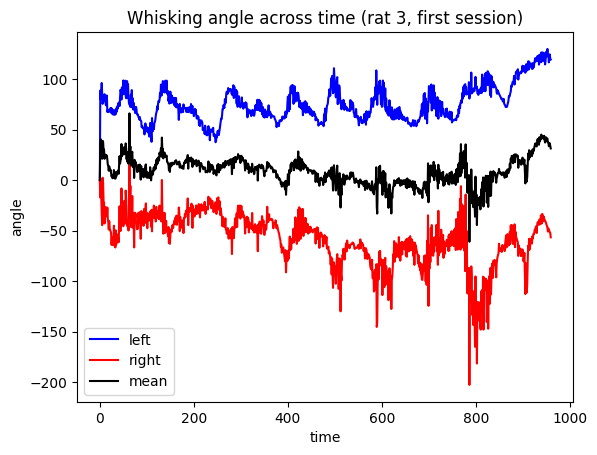

In [ ]:
plt.figure()
plt.plot(left, color="blue")
plt.plot(right, color="red")
plt.plot((left + right) / 2, color="black")
plt.legend(["left", "right", "mean"])
plt.xlabel("time")
plt.ylabel("angle")
plt.title("Whisking angle across time (rat 3, first session)")
plt.show()

Wait. But what time scale should this plot have ?

In [ ]:
framestart_hispeed = whisking["framestarthispeed"][0][0][0]
framestart_hispeed.shape

(204,)

In [ ]:
print("Number of high speed frames:", framestart_hispeed.shape[0])
print("Start frame speed:", framestart_hispeed[0])
print("End frame speed:", framestart_hispeed[-1])
assert np.all(
    framestart_hispeed == framestart_hispeed[0]
), "All high speed frames should have the same speed"

Number of high speed frames: 204
Start frame speed: 900
End frame speed: 900


In [ ]:
whisking_timestamps = whisking["timestampframestarthispeed"][0][0][0]
whisking_timestamps.shape

(204,)

In [ ]:
print(
    "Time lapse between first two frames:  {:2.2f} ms".format(
        whisking_timestamps[1] - whisking_timestamps[0]
    )
)
# Compute mean time lapse between frames
print(
    "Mean time lapse between frames: {:2.2f} ms".format(
        np.mean(np.diff(whisking_timestamps))
    )
)

Time lapse between first two frames:  19.16 ms
Mean time lapse between frames: 13.54 ms


When did the record start?

In [ ]:
# Compute start date
print("Start stamp:", whisking_timestamps[0])

Start stamp: 1224.102767


This is manifestly not a UNIX timestamp. It may be seconds since the start of the recording?

### Behavioural data

Rat `R3`.

In [ ]:
behavior = sio.loadmat(os.path.join(DATA_DIR, "R3", "Behavior.mat"))
behavior = behavior["Beha"]
behavior.dtype.names

('rat',
 'session',
 'trialnumb',
 'texture',
 'correctness',
 'startcontact',
 'stopcontact',
 'rewardtime')

#### Plot correctness

In [ ]:
behavior_correctness = behavior["correctness"][0][0][0]
behavior_correctness.shape

(312,)

In [ ]:
# Compute rat correctness over time, using sliding window
start = 0
end = len(behavior_correctness)
step = 10
width = 40
correctness_rates = []
window_range = range(start, end - width, step)
for window in window_range:
    rate = np.mean(behavior_correctness[window : window + width])
    correctness_rates.append(rate)
len(correctness_rates)

28

Text(0.5, 0.98, 'sliding window: step=10, width=40')

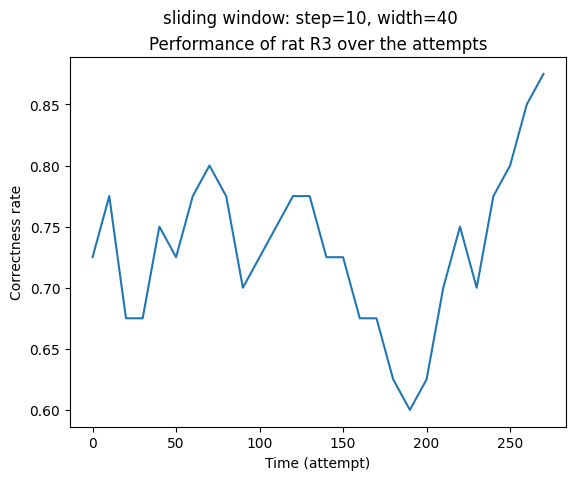

In [ ]:
plt.figure()
plt.plot(window_range, correctness_rates)
plt.xlabel("Time (attempt)")
plt.ylabel("Correctness rate")
plt.title("Performance of rat R3 over the attempts")
plt.suptitle(f"sliding window: step={step}, width={width}")

There seems to be learning and drastic loss of performance in this data.
Let's plot the texture the rat had to discriminate over time.

In [ ]:
textures = behavior["texture"][0][0][0]
textures.shape

(312,)

In [ ]:
# Compute texture time span
def texture_span(textures):
    """

    textures -- array, with categorical int values for each textures

    returns a list of tuples (texture, start, end)
    """
    i = 0
    spans = []
    texture = textures[0]
    start = 0
    end = 0
    while i < len(textures):
        if textures[i] != texture:
            end = i
            spans.append((texture, start, end))
            start = i
            texture = textures[i]
        i += 1
    spans.append((texture, start, len(textures)))
    return spans


texture_spans = texture_span(textures)
texture_spans[-1][-1]

312

This is not a really good idea. In fact in the experience, the texture was changed randomly, contrary to @lefevreSignificanceSniffingPattern2016, where the odour stayed for a period.

Text(0, 0.5, 'Texture')

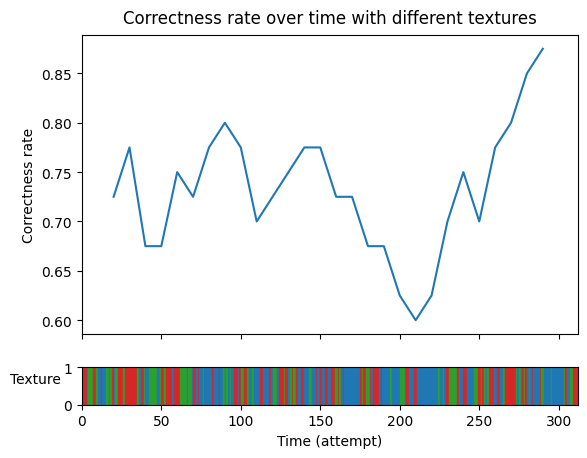

In [ ]:
# Plot texture as color rule over time
fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=[4, 0.5])
plt.title("Correctness rate over time with different textures", y=10)
# Plot the rule
for texture, start, end in texture_spans:
    axs[1].axvspan(start, end, color="C" + str(texture))
axs[1].set_xlim(0, len(textures))
axs[0].set_xlim(0, len(textures))
# Plot the correctness rate
window_range_shifted = np.array(window_range) + width / 2
axs[0].plot(window_range_shifted, correctness_rates)
axs[0].set_ylabel("Correctness rate")
plt.xlabel("Time (attempt)")
plt.ylabel("Texture", rotation=0, labelpad=20)

### Whisking - contact and phase

In [ ]:
whisking_angle.shape

(204,)

In [ ]:
contact_start = behavior["startcontact"][0][0][0]
contact_start.shape

(312,)

In [ ]:
contact_start[0]

1042.654756

This should be in seconds.

Extract a 1 second window around each contact in whisking angle data.

In `start_contact` there is the timestamps of each contact start. 
In `whisking_timestamps` there is the timestamps of each whisking angle data point.
We want to extract the whisking angle data points that are in a 1 second window around each contact start.

In [ ]:
# Let's try on the first contact
contact = contact_start[0]  # Timestamp of the first contact
print("Contact start:", contact)
# Find the closest frame
closest_frame = np.argmin(np.abs(whisking_timestamps - contact))
print("Closest frame:", closest_frame)
print("Corresponding timestamp:", whisking_timestamps[closest_frame])
# Get surrounding frames
surrounding_frames = whisking_angle[closest_frame - 10 : closest_frame + 10]

Contact start: 1042.654756
Closest frame: 126
Corresponding timestamp: 1073.858001


In [ ]:
def get_whisking_contact_surrounding(
    whisking_angle, whisking_timestamps, contact_timestamp, width=50
):
    """
    Get the whisking angles surrounding a contact

    whisking_angle -- array of whisking angles
    contact_timestamp -- timestamp of the contact
    width -- number of frames to get before and after the contact

    returns the surrounding whisking angles
    """
    closest_frame = np.argmin(np.abs(whisking_timestamps - contact_timestamp))
    if closest_frame == -1:
        return None
    return whisking_angle[closest_frame - width : closest_frame + width]

In [ ]:
surrounding_frames = []
for contact in contact_start:
    surrounding_frames.append(
        get_whisking_contact_surrounding(
            whisking_angle[0], whisking_timestamps, contact
        )
    )
len(surrounding_frames)

312

In [ ]:
# Compute the phase of all whisking angles from surrounding frames
def get_whisking_phase(whisking_angles):
    """
    Compute the phase of the whisking angles
    whisking_angles -- array of whisking angles

    returns the phase of the whisking angles

    ref. https://stackoverflow.com/a/54467135
    """
    Y = scipy.fft.fft(whisking_angles)
    f = scipy.fft.fftfreq(len(whisking_angles))
    return np.angle(Y), f

In [ ]:
first_contact_phase_angle, first_contact_phase_freq = get_whisking_phase(
    surrounding_frames[0][:, 0]
)

Text(0.5, 1.0, 'Phase of the first contact')

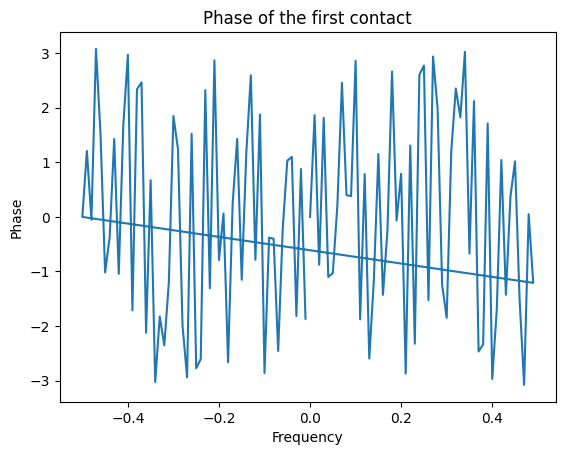

In [ ]:
plt.figure()
plt.plot(first_contact_phase_freq, first_contact_phase_angle)
plt.xlabel("Frequency")
plt.ylabel("Phase")
plt.title("Phase of the first contact")

### With Hilbert transform

In [ ]:
import os

os.chdir("../../../src/")
import tools

os.chdir("../notebooks/notebooks/whisking/")

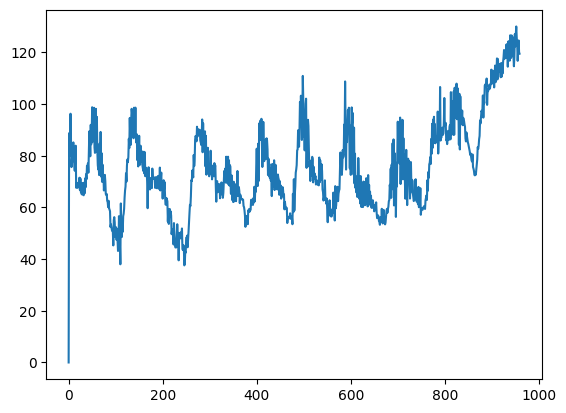

In [ ]:
plt.figure()
plt.plot(whisking_angle_first[:, 0])

In [ ]:
filtered = tools.compute_filtered_sig(
    whisking_angle_first[:, 0], 1000, 5, 15, axis=-1, target_sampling_rate=None
)

In [ ]:
tt = np.arange(0, len(whisking_angle_first[:, 0])) / 1000
tt_filter = np.arange(0, len(filtered[0])) / filtered[1]

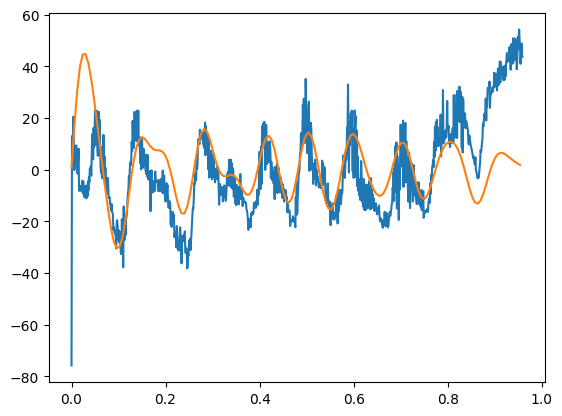

In [ ]:
plt.figure()
plt.plot(tt, whisking_angle_first[:, 0] - np.mean(whisking_angle_first[:, 0]))
plt.plot(tt_filter, filtered[0])

In [ ]:
env_times, env_ampl, env_phase, env_sampling_rate = tools.compute_hilbert_envelope(
    whisking_angle_first[:, 0],
    1000,
    5,
    15,
)

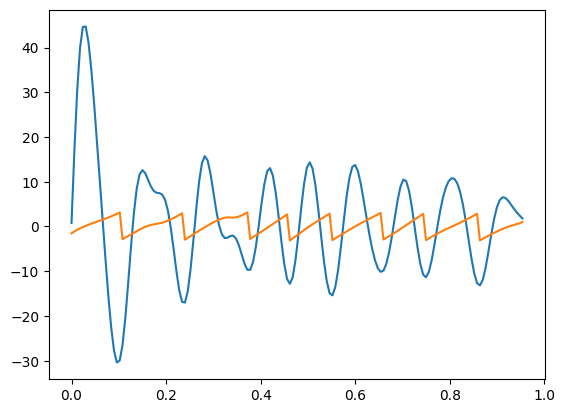

In [ ]:
plt.plot(env_times, env_ampl * np.cos(env_phase))
plt.plot(env_times, env_phase)